In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import pickle
from tqdm import tqdm_notebook as tqdm

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
import readdy_learn.analyze.cross_validation as cross_validation
from pathos.multiprocessing import Pool

import pynumtools.kmc as kmc

mpl.rcParams['figure.figsize'] = (16, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork
from readdy_learn.example.regulation_network import sample_lsq_rates
from readdy_learn.example.regulation_network import sample_along_alpha
from readdy_learn.example.regulation_network import DEFAULT_DESIRED_RATES

In [17]:
def get_bfc_custom():
    # species DA  MA  A  DB  MB  B  DC  MC  C
    # ids     0   1   2  3   4   5  6   7   8
    bfc = basis.BasisFunctionConfiguration(9)
    # usual stuff A
    bfc.add_fission(0, 0, 1)  # 0   DA -> DA + MA, transcription A
    bfc.add_fission(1, 1, 2)  # 1   MA -> MA + A, translation A
    bfc.add_decay(1)  # 2   MA -> 0, decay
    bfc.add_decay(2)  # 3   A -> 0, decay
    # usual stuff B
    bfc.add_fission(3, 3, 4)  # 4   DB -> DB + MB, transcription B
    bfc.add_fission(4, 4, 5)  # 5   MB -> MB + B, translation B
    bfc.add_decay(4)  # 6   MB -> 0, decay
    bfc.add_decay(5)  # 7   B -> 0, decay
    # usual stuff C
    bfc.add_fission(6, 6, 7)  # 8   DC -> DC + MC, transcription C
    bfc.add_fission(7, 7, 8)  # 9   MC -> MC + C, translation C
    bfc.add_decay(7)  # 10  MC -> 0, decay
    bfc.add_decay(8)  # 11  C -> 0, decay

    # all possible regulations
    # self regulation
    bfc.add_fusion(1, 2, 2)  # 12  MA + A -> A, A regulates A
    bfc.add_fusion(4, 5, 5)  # 13  MB + B -> B, B regulates B
    bfc.add_fusion(7, 8, 8)  # 14  MC + C -> C, C regulates C
    # cyclic forward
    bfc.add_fusion(4, 2, 2)  # 15  MB + A -> A, A regulates B
    bfc.add_fusion(7, 5, 5)  # 16  MC + B -> B, B regulates C
    bfc.add_fusion(1, 8, 8)  # 17  MA + C -> C, C regulates A
    # cyclic backward
    bfc.add_fusion(7, 2, 2)  # 18  MC + A -> A, A regulates C
    bfc.add_fusion(4, 8, 8)  # 19  MB + C -> C, C regulates B
    bfc.add_fusion(1, 5, 5)  # 20  MA + B -> B, B regulates A

    # thrown these out due to being identical to decay
    # nonsense reactions, DNA eats mRNA self
    # bfc.add_fusion(1, 0, 0) # 21 MA + DA -> DA
    # bfc.add_fusion(4, 3, 3) # 22 MB + DB -> DB
    # bfc.add_fusion(7, 6, 6) # 23 MC + DC -> DC

    # nonsense reactions, DNA eats mRNA cyclic forward
    # bfc.add_fusion(4, 0, 0) # 24 MB + DA -> DA
    # bfc.add_fusion(7, 3, 3) # 25 MC + DB -> DB
    # bfc.add_fusion(1, 6, 6) # 26 MA + DC -> DC

    # nonsense reactions, DNA eats mRNA cyclic backward
    # bfc.add_fusion(7, 0, 0) # 27 MC + DA -> DA
    # bfc.add_fusion(4, 6, 6) # 28 MB + DC -> DC
    # bfc.add_fusion(1, 3, 3) # 29 MA + DB -> DB

    # nonsense reactions, mRNA eats protein self
    bfc.add_fusion(1, 2, 1)  # 21 MA + A -> MA
    bfc.add_fusion(4, 5, 4)  # 22 MB + B -> MB
    bfc.add_fusion(7, 8, 8)  # 23 MC + C -> MC

    # nonsense reactions, mRNA eats protein cyclic forward
    bfc.add_fusion(1, 5, 1)  # 24 MA + B -> MA
    bfc.add_fusion(4, 8, 4)  # 25 MB + C -> MB
    bfc.add_fusion(7, 2, 7)  # 26 MC + A -> MC

    # nonsense reactions, mRNA eats protein  cyclic backward
    bfc.add_fusion(1, 8, 1)  # 27 MA + C -> MA
    bfc.add_fusion(4, 2, 4)  # 28 MB + A -> MB
    bfc.add_fusion(7, 4, 7)  # 29 MC + B -> MC

    # nonsense reactions, protein eats protein self
    bfc.add_fusion(2, 2, 2)  # 30 A + A -> A
    bfc.add_fusion(5, 5, 5)  # 31 B + B -> B
    bfc.add_fusion(8, 8, 8)  # 32 C + C -> C

    # nonsense reactions, protein eats protein cyclic forward
    bfc.add_fusion(5, 2, 2)  # 30 B + A -> A
    bfc.add_fusion(8, 5, 5)  # 31 C + B -> B
    bfc.add_fusion(2, 8, 8)  # 32 A + C -> C

    # nonsense reactions, protein eats protein cyclic backward
    bfc.add_fusion(8, 2, 2)  # 33 C + A -> A
    bfc.add_fusion(5, 8, 8)  # 34 B + C -> C
    bfc.add_fusion(2, 5, 5)  # 35 A + B -> B

    # nonsense reactions, protein becomes protein cyclic forward
    bfc.add_conversion(2, 5)  # 36 A -> B
    bfc.add_conversion(5, 8)  # 37 B -> C
    bfc.add_conversion(8, 2)  # 38 C -> A

    # nonsense reactions, protein becomes protein cyclic backward
    bfc.add_conversion(2, 8)  # 39 A -> C
    bfc.add_conversion(8, 5)  # 40 C -> B
    bfc.add_conversion(5, 2)  # 41 B -> A

    # random reactions
    get_additional_funs(bfc)
    return bfc


def get_additional_funs(bfc):
    # species DA  MA  A  DB  MB  B  DC  MC  C
    # ids     0   1   2  3   4   5  6   7   8
    #bfc.add_fusion(4, 7, 1)  # MB + MC -> MA, ok (causes lsq trouble)
    #bfc.add_fusion(2, 7, 8)  # A + MC -> C, ok (causes lsq trouble)
    pass


def get_n_additional_funs():
    return 0


DESIRED_RATES = np.array([
    1.8,  # DA -> DA + MA, transcription A
    2.1,  # MA -> MA + A, translation A
    1.3,  # MA -> 0, decay
    1.5,  # A -> 0, decay
    2.2,  # DB -> DB + MB, transcription B
    2.0,  # MB -> MB + B, translation B
    2.0,  # MB -> 0, decay
    2.5,  # B -> 0, decay
    3.2,  # DC -> DC + MC, transcription C
    3.0,  # MC -> MC + C, translation C
    2.3,  # MC -> 0, decay
    2.5,  # C -> 0, decay
    # self regulation
    0.,  # MA + A -> A, A regulates A
    0.,  # MB + B -> B, B regulates B
    0.,  # MC + C -> C, C regulates C
    # cyclic forward
    0.,  # MB + A -> A, A regulates B
    0.,  # MC + B -> B, B regulates C
    0.,  # MA + C -> C, C regulates A
    # cyclic backward
    6.,  # MC + A -> A, A regulates C
    4.,  # MB + C -> C, C regulates B
    3.,  # MA + B -> B, B regulates A
    # nonsense reactions, mRNA eats protein self
    0., 0., 0.,
    # nonsense reactions, mRNA eats protein cyclic forward
    0., 0., 0.,
    # nonsense reactions, mRNA eats protein  cyclic backward
    0., 0., 0.,
    # nonsense reactions, protein eats protein self
    0., 0., 0.,
    # nonsense reactions, protein eats protein cyclic forward
    0., 0., 0.,
    # nonsense reactions, protein eats protein cyclic backward
    0., 0., 0.,
    # nonsense reactions, protein becomes protein cyclic forward
    0., 0., 0.,
    # nonsense reactions, protein becomes protein cyclic backward
    0., 0., 0.,
])

desired_rates = np.append(DESIRED_RATES, np.zeros((get_n_additional_funs(),)))


def get_regulation_network(timestep, noise=0., target_time=3., gillespie_realisations=None, scale=1.):
    assert np.floor(scale) == scale
    print("obtaining regulation network with dt = {}".format(timestep))
    regulation_network = RegulationNetwork()
    regulation_network.timestep = timestep
    regulation_network.realisations = 1.
    regulation_network.noise_variance = noise
    regulation_network.get_bfc = get_bfc_custom
    regulation_network.desired_rates = desired_rates
    regulation_network.target_time = target_time
    regulation_network.initial_states = [regulation_network.initial_states[1]]

    if scale > 1.:
        print("scaling population up, timestep down and bimol. rates down by factor {}".format(scale))
        regulation_network.desired_rates[18:21] /= scale
        regulation_network.initial_states = [
            [regulation_network.initial_states[0][i] * scale 
             for i in range(len(regulation_network.initial_states[0]))]
        ]
        regulation_network.timestep /= scale

    analysis = regulation_network.generate_analysis_object(fname_prefix='case_2', fname_postfix='0')
    if gillespie_realisations is not None:
        print("generating data using gillespie kmc averaged over {} realisations".format(gillespie_realisations))
        for i in range(len(regulation_network.initial_states)):
            analysis.generate_or_load_traj_gillespie(i, target_time=target_time, 
                                                     n_realizations=gillespie_realisations,
                                                     update_and_persist=False, njobs=8)
    else:
        print("generating data by integrating the law of mass action with additive noise {}".format(
            regulation_network.noise_variance))
        for i in range(len(regulation_network.initial_states)):
            analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                               noise_variance=regulation_network.noise_variance,
                                               realizations=regulation_network.realisations)

    # before calculating derivatives scale population down again, timestep and bimolecular reaction rates up again
    if scale > 1.:
        for traj in analysis.trajs:
            traj.counts = traj.counts[::int(scale)] / scale
            traj.time_step = regulation_network.timestep * scale
            traj.update()
        regulation_network.desired_rates[18:21] *= scale
        regulation_network.timestep *= scale
        regulation_network.initial_states = [[regulation_network.initial_states[0][i] / scale 
                                              for i in range(len(regulation_network.initial_states[0]))]]
    regulation_network.compute_gradient_derivatives(analysis, persist=False)
    print(regulation_network.timestep)
    analysis2 = regulation_network.generate_analysis_object(fname_prefix='case_2', fname_postfix='0')
    print(analysis2.timestep)
    analysis2._trajs = analysis.trajs
    for i in range(len(regulation_network.initial_states)):
        traj = analysis.get_traj(i)
    
    return regulation_network, analysis2

In [18]:
noise = 1e-6
dt = 4e-3
gillespie_realizations = 10
target_time=3
scale=500

In [19]:
regulation_network, analysis = get_regulation_network(dt, noise=noise, target_time=target_time, 
                                                      gillespie_realisations=gillespie_realizations, scale=scale)

obtaining regulation network with dt = 0.004
scaling population up, timestep down and bimol. rates down by factor 500
generating data using gillespie kmc averaged over 10 realisations


HBox(children=(HBox(children=(Label(value='generate averaged kmc 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

0.004
0.004


In [22]:
regulation_network.desired_rates

array([1.8, 2.1, 1.3, 1.5, 2.2, 2. , 2. , 2.5, 3.2, 3. , 2.3, 2.5, 0. ,
       0. , 0. , 0. , 0. , 0. , 6. , 4. , 3. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. ])

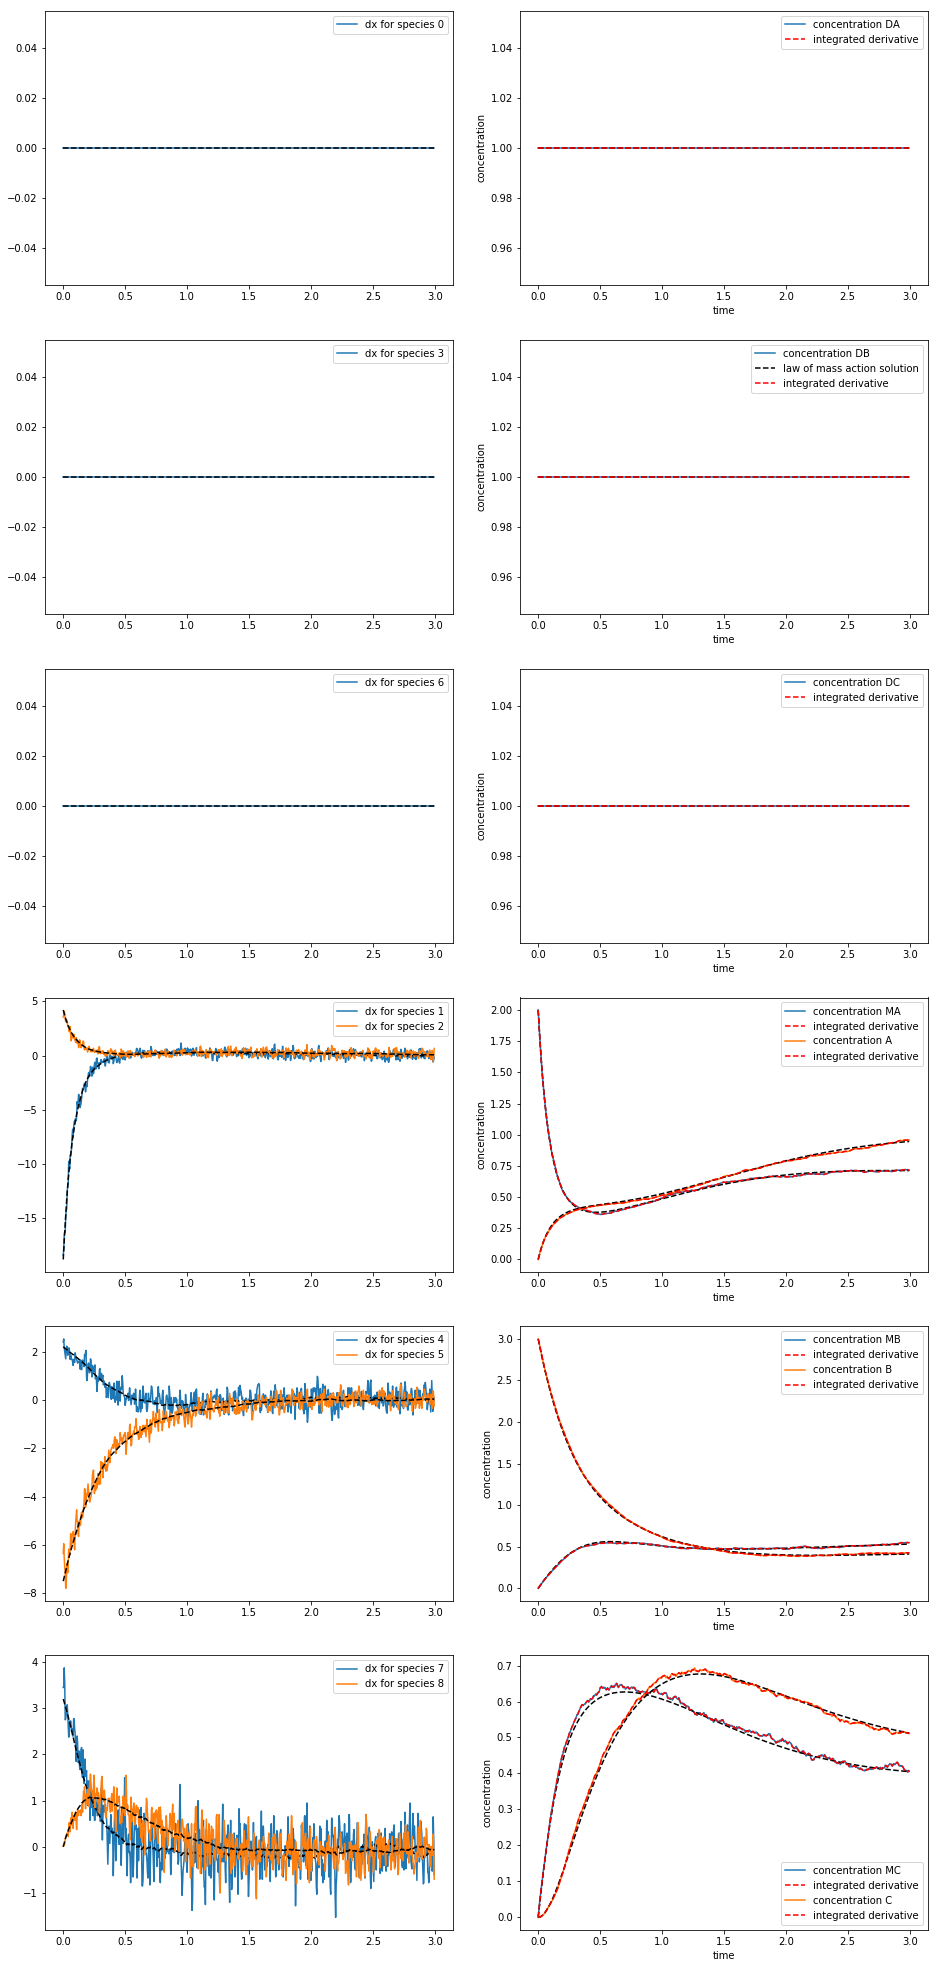

In [21]:
regulation_network.plot_concentrations(analysis, 0)

In [24]:
rates = []
alphas = np.logspace(-15, -1, num=50)

with Pool(processes=8) as p:
    worker = lambda a: (a, analysis.solve(0, a, 1., tol=1e-15, persist=False, recompute=True, verbose=False))
    ix = 0
    for tup in tqdm(p.imap(worker, alphas, chunksize=1), total=len(alphas)):
        alpha, r = tup
        assert alphas[ix] == alpha
        ix += 1
        rates.append(r)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

In [25]:
l1_errs = []
for rate in rates:
    l1_errs.append(np.sum(np.abs(rate - regulation_network.desired_rates)))

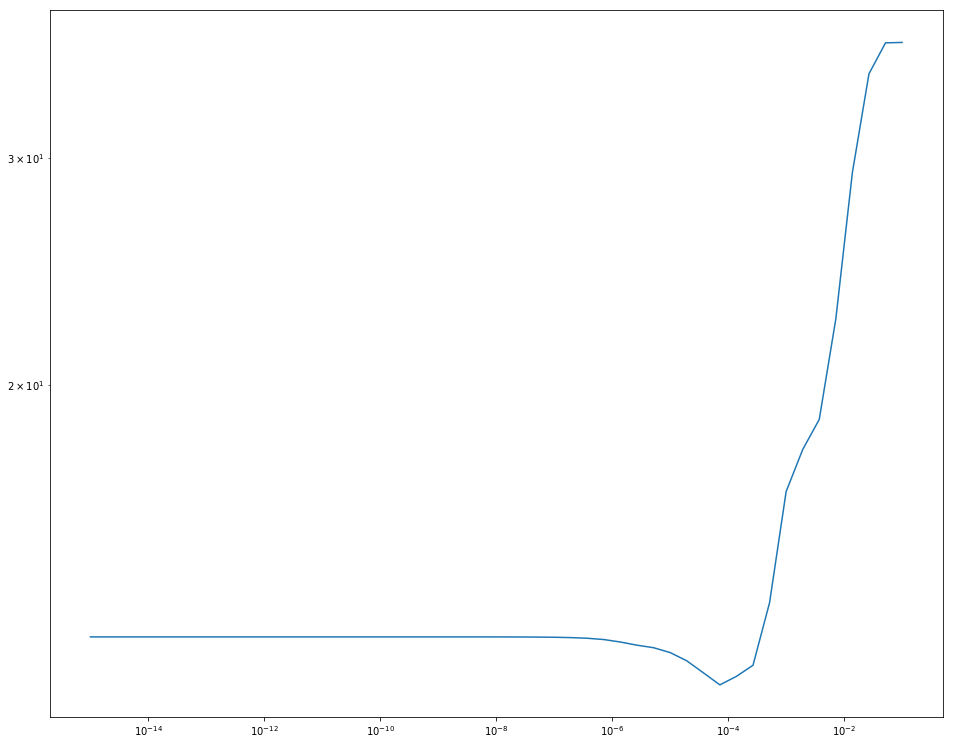

In [26]:
plt.loglog(alphas, l1_errs)

# why does it scale down the rates even though they are scaled back wtf

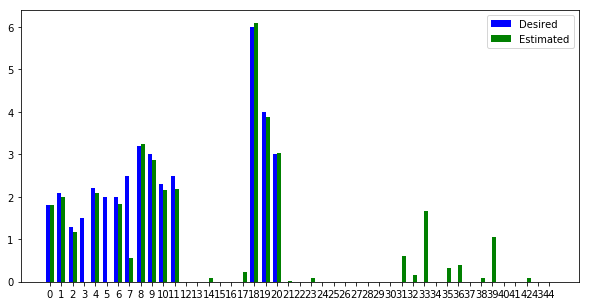

In [28]:
ana.plot_rates_bar(regulation_network.desired_rates, rates[np.argmin(l1_errs)])

In [29]:
alphas[np.argmin(l1_errs)]

7.196856730011499e-05

In [32]:
regulation_network.desired_rates

array([1.8, 2.1, 1.3, 1.5, 2.2, 2. , 2. , 2.5, 3.2, 3. , 2.3, 2.5, 0. ,
       0. , 0. , 0. , 0. , 0. , 6. , 4. , 3. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. ])

In [40]:
cv = cross_validation.get_cross_validation_object(regulation_network)
cv.n_splits = 5
cv.njobs = 8
cv.splitter = 'kfold'

In [41]:
alphas = np.logspace(-7, -1, num=8*4)
l1_ratios = np.array([1.]) # np.linspace(0, 1, num=5)
result = cv.cross_validate(alphas, l1_ratios, realizations=1)

validating across grid with 32 alphas, 1 lambdas, 1 cutoffs with 1 realizations


HBox(children=(HBox(children=(Label(value='validation 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=32), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [42]:
result

[{'alpha': 1.4497406703726316e-06,
  'cutoff': 0.0,
  'l1_ratio': 1.0,
  'score': [-1.1373759491925128,
   -0.13188566575556696,
   -0.13286598904153704,
   -0.13624773265071802,
   -0.15108951978413326]},
 {'alpha': 2.2638034095214464e-06,
  'cutoff': 0.0,
  'l1_ratio': 1.0,
  'score': [-1.3438870712891113,
   -0.13188234655006625,
   -0.1328655978880122,
   -0.13625081292807503,
   -0.1510692156853317]},
 {'alpha': 1.5615230060004964e-07,
  'cutoff': 0.0,
  'l1_ratio': 1.0,
  'score': [-1.3023117227588479,
   -0.13189223449347245,
   -0.13286715161040927,
   -0.13624145582150163,
   -0.15107696780442845]},
 {'alpha': 9.284145445194745e-07,
  'cutoff': 0.0,
  'l1_ratio': 1.0,
  'score': [-1.2327685994529158,
   -0.13188808950168698,
   -0.13286640686422854,
   -0.13624477055757414,
   -0.1510870000043311]},
 {'alpha': 5.945570708544394e-07,
  'cutoff': 0.0,
  'l1_ratio': 1.0,
  'score': [-1.3121178974999357,
   -0.13188980019615767,
   -0.1328667167974269,
   -0.13624318035024133,
   

In [46]:
result_l11 = [r for r in result if r['l1_ratio'] == 1.]

In [47]:
xs = []
ys = []
ys1 = []
ys2 = []
yerr = []
alphas = sorted([r['alpha'] for r in result_l11])
for alpha in alphas:
    for r in result_l11:
        if r['alpha'] == alpha:
            xs.append(alpha)
            ys.append(np.mean(r['score'])) # np.mean(r['score'])
            yerr.append(np.std(r['score']))
            ys1.append(r['score'][1])
            ys2.append(r['score'][2])
            
ys = np.asarray(ys)
yerr = np.asarray(yerr)
ys1 = np.asarray(ys1)
ys2 = np.asarray(ys2)

print("best alpha: {}".format(xs[np.argmax(ys)]))

best alpha: 1.4497406703726316e-06


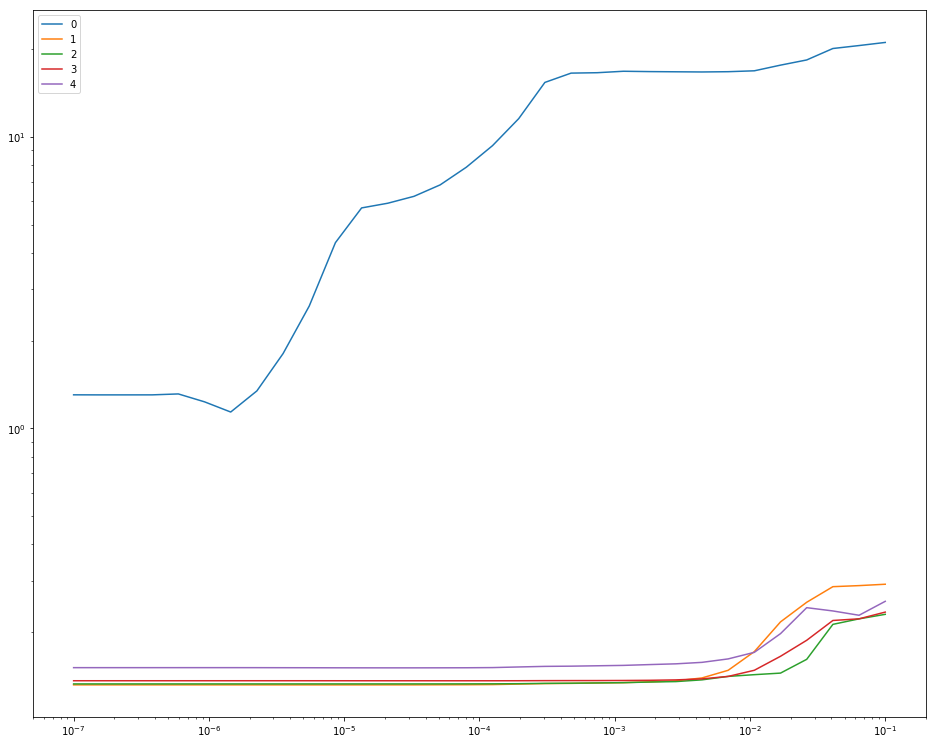

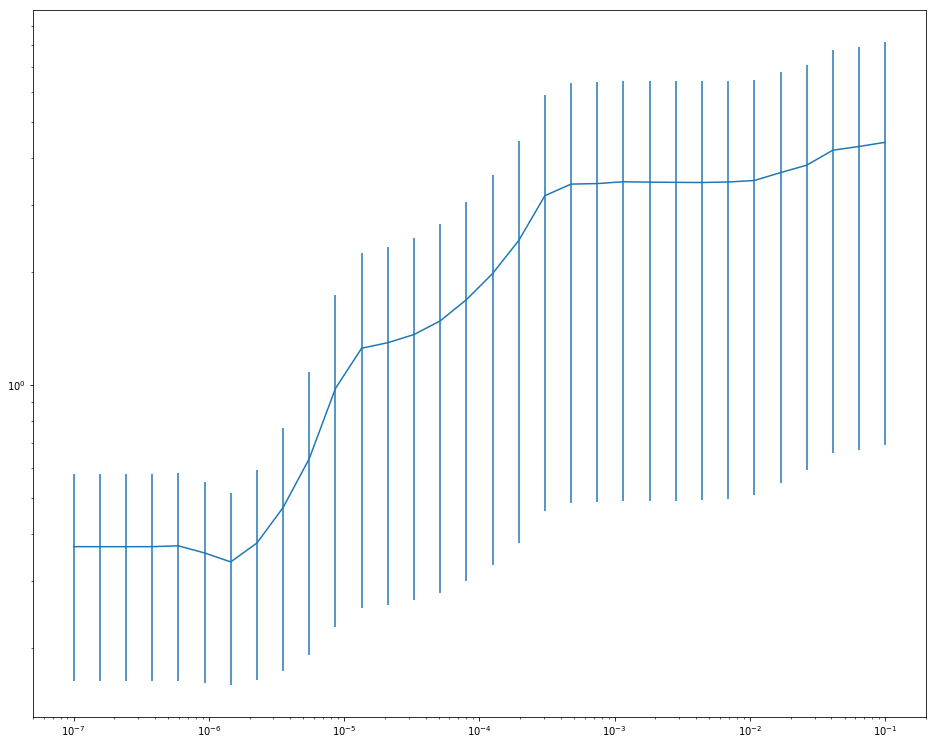

In [63]:
xxs = []
yys = [[] for _ in range(len(result[0]['score']))]
for alpha in alphas:
    for r in result_l11:
        if np.isclose(r['alpha'], alpha):
            xxs.append(alpha)
            for ix, score in enumerate(r['score']):
                yys[ix].append(score)
for i in range(len(yys)):
    plt.plot(xxs, -np.array(yys[i]), label='{}'.format(i))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.errorbar(xxs, -ys, yerr=yerr / np.sqrt(len(yys)))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [64]:
rates = analysis.solve(0, xs[np.argmax(ys)], 1., tol=1e-15, persist=False, recompute=True, verbose=False)

In [65]:
regulation_network.desired_rates

array([1.8, 2.1, 1.3, 1.5, 2.2, 2. , 2. , 2.5, 3.2, 3. , 2.3, 2.5, 0. ,
       0. , 0. , 0. , 0. , 0. , 6. , 4. , 3. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. ])

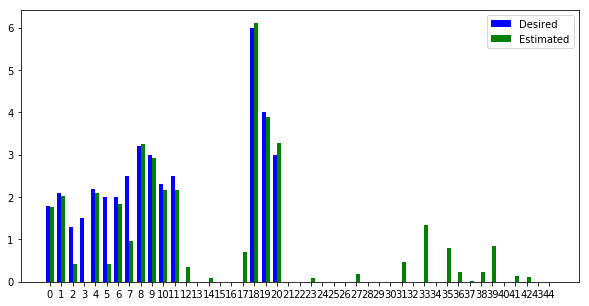

In [67]:
ana.plot_rates_bar(regulation_network.desired_rates, rates)